# 준비

- Mecab 다운로드
- tensorflow 다운로드
- Gpu 연결 확인
- 기타 라이브러리 및 패키지 다운로드

In [3]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 76.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [konlpy]2m2/3 [konlpy]
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/home/jovyan/work/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab_light_220429.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-09-07 21:40:01--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.134, 13.200.41.136, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.135|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeo

In [4]:
!pip install --no-cache-dir --upgrade pip
!pip install --no-cache-dir "tensorflow[and-cuda]==2.20.*"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 183.2 MB/s  0:00:030:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 232.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 208.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 197.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 188.9 MB/s  0:00:03eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 200.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 193.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 137.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)
print("GPU 메모리 growth 설정 완료")


2025-09-07 21:45:43.803254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 메모리 growth 설정 완료


In [2]:
import os, re, unicodedata, html
import urllib.request
import zipfile
import pandas as pd

from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.7.1+cu118


# 계획 세우기

학습 목표:

1. 데이터를 다운받고 전처리를 해야 한다.
2. seq2seq 모델을 훈련시키면서 training loss가 떨어지는 것을 확인한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되어야 한다.

In [3]:
import tarfile

file_path = "s2s_translation/korean-english-park.train.tar.gz"
extract_path = "s2s_translation/"

#with tarfile.open(file_path, "r:gz") as tar:
#    tar.extractall(path=extract_path)
#    print("압축 해제 완료!")

In [4]:
import re
from pathlib import Path

EN_PATH = "s2s_translation/korean-english-park.train.en"
KO_PATH = "s2s_translation/korean-english-park.train.ko"
MAX_LEN = 40  # 토큰 길이 상한

def read_lines(path: str):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {path}")
    with path.open(encoding="utf-8") as f:
        return [ln.strip() for ln in f]

In [5]:
# 1) 데이터 확인하기
raw_en = read_lines(EN_PATH)
raw_ko = read_lines(KO_PATH)

# assert로 문장수 일치를 확인
assert len(raw_en) == len(raw_ko), f"영/한 문장수 불일치: {len(raw_en)} vs {len(raw_ko)}"

In [6]:
# 2) 전처리 함수 만들기
_spaces = re.compile(r"\s+")

# 영어: 알파벳/숫자/공백/기본 문장부호 외 제거
_en_keep = re.compile(r"[^a-z0-9\s.,!?;:'\"()\-\u2019\u201c\u201d]")

# 한글: 완성형 한글(가-힣) + 숫자/영문/공백/기본 문장부호 허용
_ko_keep = re.compile(r"[^0-9a-zA-Z\uAC00-\uD7A3\s.,!?~…'\"()\-\u2019\u201c\u201d]")

def _normalize_spaces(s: str) -> str:
    return _spaces.sub(" ", s).strip()

def preprocessing(text: str, lang: str) -> str:
    if not text:
        return ""
    # 따옴표/하이픈류 통일
    text = (text
            .replace("’", "'").replace("‘", "'")
            .replace("“", '"').replace("”", '"')
            .replace("–", "-").replace("—", "-"))
    if lang.lower() == "en":
        s = text.lower()
        s = _en_keep.sub(" ", s)       # 허용하지 않는 문자 제거
        s = _normalize_spaces(s)
        return s
    elif lang.lower() == "ko":
        s = _ko_keep.sub(" ", text)    # 허용하지 않는 문자 제거
        s = _normalize_spaces(s)
        return s
    else:
        # 기본: 공백 정리만
        return _normalize_spaces(text)


In [7]:
# 3) 정제 + 중복 제거 (set 이용, 순서 보존)
cleaned_corpus = []              # 정제한 결과를 담는 리스트
seen = set()                     # set of tuple(en, ko) 중복 여부 확인

for en, ko in zip(raw_en, raw_ko):
    en_c = preprocessing(en, "en")
    ko_c = preprocessing(ko, "ko")
    
    if not en_c or not ko_c:
        continue # 결과가 비면 통과
        
    pair = (en_c, ko_c)  #set에는 튜플이 들어갈 수 있음
    if pair in seen:
        continue #이미 본 pair면 스킵
    seen.add(pair) # 처음 보는 pair면 추가
    cleaned_corpus.append(pair) # 결과에도 추가

print(f"처음 데이터 쌍: {len(raw_en):,} → 정제/중복제거 후: {len(cleaned_corpus):,}")

처음 데이터 쌍: 94,123 → 정제/중복제거 후: 78,928


=======================

예시 전처리 전:
```
EN: ["Hello!", "Thanks  ", "Hello"]
KO: ["안녕!",  "고마워",     "안녕 ! "]
```

예시 전처리 후:

```
("hello", "안녕")
("thanks", "고마워")
("hello", "안녕")
```



In [8]:
# 4) 토큰화
try:
    from konlpy.tag import Mecab
    mecab = Mecab()
    use_mecab = True
except Exception as e:
    # 과제 요구는 Mecab 사용이지만, 환경 미구축 시 임시 fall-back 제공
    print("⚠️ KoNLPy Mecab을 사용할 수 없습니다. (설치 후 재실행 권장)\n", e)
    print("임시로 한글은 공백 토큰화로 진행합니다.")
    mecab = None
    use_mecab = False

eng_corpus = []   # List[List[str]]
kor_corpus = []   # List[List[str]]

for en_c, ko_c in cleaned_corpus:
    # 영어: <start>, <end> 추가 + 공백 split
    en_tokens = ["<start>"] + en_c.split() + ["<end>"]
    # 한국어: Mecab 형태소 단위
    if use_mecab:
        ko_tokens = mecab.morphs(ko_c)
    else:
        ko_tokens = ko_c.split()

    # 5) 길이 필터링 (양쪽 모두 MAX_LEN 이하)
    if len(en_tokens) <= MAX_LEN and len(ko_tokens) <= MAX_LEN:
        eng_corpus.append(en_tokens)
        kor_corpus.append(ko_tokens)

print(f"길이 ≤ {MAX_LEN} 토큰 필터링 후 남은 쌍: {len(eng_corpus):,}")

길이 ≤ 40 토큰 필터링 후 남은 쌍: 61,497


In [9]:
# 샘플 확인
for i in range(min(3, len(eng_corpus))):
    print(f"[{i}] EN:", " ".join(eng_corpus[i][:20]))
    print(f"    KO:", "/".join(kor_corpus[i][:20]))

[0] EN: <start> much of personal computing is about "can you top this?" <end>
    KO: 개인/용/컴퓨터/사용/의/상당/부분/은/"/이것/보다/뛰어날/수/있/느냐/?/"
[1] EN: <start> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
    KO: 모든/광/마우스/와/마찬가지/로/이/광/마우스/도/책상/위/에/놓/는/마우스/패드/를/필요/로
[2] EN: <start> like all optical mice, but it also doesn't need a desk. <end>
    KO: 그러나/이것/은/또한/책상/도/필요/로/하/지/않/는다/.


In [10]:
# 3. 데이터 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
# 하이퍼파라미터(실험으로 조정하세요. 최소 10,000 이상 권장)
EN_MAX_WORDS = 20000
KO_MAX_WORDS = 20000
PAD_ID = 0  # pad_sequences가 패딩에 사용하는 값

def join_tokens(list_of_tokens):
    """['I', 'like', 'you'] -> 'I like you'"""
    return " ".join(list_of_tokens)

def tokenize(tokens_list, num_words=None, lower=False):
    """
    tokens_list: List[List[str]]  (이미 토큰화된 문장 목록)
    return: tokenizer, sequences(List[List[int]])
    """
    # 토크나이저가 자체 토큰분해를 하지 않도록 filters 제거, split=' '
    tok = Tokenizer(num_words=num_words, oov_token="<unk>", filters="", lower=lower, split=" ")
    texts = [join_tokens(toks) for toks in tokens_list]
    tok.fit_on_texts(texts)
    seqs = tok.texts_to_sequences(texts)
    return tok, seqs


In [12]:
# 1) 한국어(인코더 입력) 토큰화
ko_tokenizer, ko_sequences = tokenize(kor_corpus, num_words=KO_MAX_WORDS, lower=False)

# 2) 영어(디코더 입력/출력) 토큰화
#    ※ 영어는 2단계에서 이미 <start> ... <end> 토큰이 포함되어 있다고 가정
en_tokenizer, en_sequences = tokenize(eng_corpus, num_words=EN_MAX_WORDS, lower=False)

# 3) 디코더 입력/출력 시퀀스 만들기 (teacher forcing 용)
#    decoder_input: <start> ... <end-1>
#    decoder_target: ... <end>
en_input_sequences  = [seq[:-1] for seq in en_sequences]  # 오른쪽 한 칸 제거
en_target_sequences = [seq[1:]  for seq in en_sequences]  # 왼쪽 한 칸 제거

# 4) 패딩 (post-padding, 길이=MAX_LEN)
encoder_input = pad_sequences(ko_sequences, maxlen=MAX_LEN, padding="post", truncating="post", value=PAD_ID)
decoder_input = pad_sequences(en_input_sequences, maxlen=MAX_LEN, padding="post", truncating="post", value=PAD_ID)
decoder_target = pad_sequences(en_target_sequences, maxlen=MAX_LEN, padding="post", truncating="post", value=PAD_ID)


# 5) 실제 사용되는 어휘 크기(패딩 0 포함하려면 +1)
en_vocab_size = min(EN_MAX_WORDS, len(en_tokenizer.word_index) + 1)
ko_vocab_size = min(KO_MAX_WORDS, len(ko_tokenizer.word_index) + 1)

print("=== Tokenization Done ===")
print(f"KO vocab size: {ko_vocab_size:,}  | EN vocab size: {en_vocab_size:,}")
print(f"encoder_input shape : {encoder_input.shape}")  # (N, 40)
print(f"decoder_input shape : {decoder_input.shape}")  # (N, 40)
print(f"decoder_target shape: {decoder_target.shape}") # (N, 40)

=== Tokenization Done ===
KO vocab size: 20,000  | EN vocab size: 20,000
encoder_input shape : (61497, 40)
decoder_input shape : (61497, 40)
decoder_target shape: (61497, 40)


In [13]:
# 샘플 확인
idx = 0
print("\n[Sample check]")
print("KO seq:", encoder_input[idx][:20])
print("EN in :", decoder_input[idx][:20])
print("EN out:", decoder_target[idx][:20])


[Sample check]
KO seq: [ 776  605  568  192    7 1449  911    8   18  734  175    1   44   15
 3782  301   18    0    0    0]
EN in : [    3   240     6  1297 10099    12    40 17198    94   183     1     0
     0     0     0     0     0     0     0     0]
EN out: [  240     6  1297 10099    12    40 17198    94   183     1     4     0
     0     0     0     0     0     0     0     0]


In [14]:
# 토크나이저가 특정 토큰을 어떻게 인덱싱했는지 확인
for tok_name, tok in [("EN", en_tokenizer), ("KO", ko_tokenizer)]:
    print(f"\n[{tok_name} tokenizer] top-10 tokens:")
    inv = sorted(tok.word_index.items(), key=lambda x: x[1])[:10]
    for w, i in inv:
        print(f"  {i:>4}: {w}")


[EN tokenizer] top-10 tokens:
     1: <unk>
     2: the
     3: <start>
     4: <end>
     5: to
     6: of
     7: a
     8: in
     9: and
    10: for

[KO tokenizer] top-10 tokens:
     1: <unk>
     2: .
     3: 다
     4: 이
     5: 는
     6: 을
     7: 의
     8: 은
     9: 에
    10: 했


In [15]:
# ===== 4. 모델 설계: Attention 기반 Seq2Seq =====

import tensorflow as tf
from tensorflow.keras import layers, Model

#깨끗한 그래프에서 시작하기
tf.keras.backend.clear_session()

# 전 단계에서 이미 준비된 것들:
# - encoder_input, decoder_input, decoder_target  (모두 (N, MAX_LEN) int32)
# - ko_tokenizer, en_tokenizer
# - ko_vocab_size, en_vocab_size
# - MAX_LEN = 40

# ===== 하이퍼파라미터  =====
EMB_KO   = 256    # 한국어 임베딩 차원
EMB_EN   = 256    # 영어 임베딩 차원
HID_UNITS= 512    # GRU hidden size
DROPOUT  = 0.2
LR       = 1e-3
BATCH    = 128
EPOCHS   = 10


# === 1) Input을 먼저 정의 ===
enc_in = layers.Input(shape=(MAX_LEN,), dtype='int32', name='enc_in')
dec_in = layers.Input(shape=(MAX_LEN,), dtype='int32', name='dec_in')

# === 2) 마스크는 Input으로부터 생성  ===
enc_mask_bool  = layers.Lambda(lambda x: tf.not_equal(x, 0), name='enc_mask_bool')(enc_in)   # (B, T_enc) bool
enc_mask_float = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32),
                               name='enc_mask_float')(enc_in)                                 # (B, T_enc) float
dec_mask_float = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32),
                               name='dec_mask_float')(dec_in)                                 # (B, T_dec) float

# === 3) Embedding: mask_zero=False + 수동 마스크 곱 ===
enc_emb_raw = layers.Embedding(ko_vocab_size, EMB_KO, mask_zero=False, name='enc_emb')(enc_in)
enc_emb = layers.Multiply(name='enc_apply_mask')([
    enc_emb_raw,
    layers.Lambda(lambda m: tf.expand_dims(m, -1))(enc_mask_float)
])

dec_emb_raw = layers.Embedding(en_vocab_size, EMB_EN, mask_zero=False, name='dec_emb')(dec_in)
dec_emb = layers.Multiply(name='dec_apply_mask')([
    dec_emb_raw,
    layers.Lambda(lambda m: tf.expand_dims(m, -1))(dec_mask_float)
])

# === 4) Encoder / Decoder ===
enc_gru = layers.GRU(HID_UNITS, return_sequences=True, return_state=True,
                     activation='tanh', recurrent_activation='sigmoid',
                     reset_after=True, recurrent_dropout=0.0,
                     dropout=DROPOUT, name='enc_gru')
dec_gru = layers.GRU(HID_UNITS, return_sequences=True, return_state=True,
                     activation='tanh', recurrent_activation='sigmoid',
                     reset_after=True, recurrent_dropout=0.0,
                     dropout=DROPOUT, name='dec_gru')


enc_out, enc_state = layers.GRU(HID_UNITS, return_sequences=True, return_state=True,
                                dropout=DROPOUT, name='enc_gru')(enc_emb)
dec_out_seq, _ = layers.GRU(HID_UNITS, return_sequences=True, return_state=True,
                            dropout=DROPOUT, name='dec_gru')(dec_emb, initial_state=enc_state)

# === 5) Bahdanau Attention ===
class BahdanauAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.W1 = layers.Dense(units, use_bias=False)
        self.W2 = layers.Dense(units, use_bias=False)
        self.V  = layers.Dense(1,    use_bias=False)

    def call(self, query, values, mask=None):
        score = self.V(
            tf.nn.tanh(
                tf.expand_dims(self.W1(values), axis=1) +  # (B,1,T_v,U)
                tf.expand_dims(self.W2(query),  axis=2)     # (B,T_q,1,U)
            )
        )  # (B, T_q, T_v, 1)
        score = tf.squeeze(score, axis=-1)                  # (B, T_q, T_v)
        if mask is not None:                                # mask: (B, T_v)
            mask = tf.cast(mask, tf.float32)
            score += (1.0 - tf.expand_dims(mask, 1)) * (-1e9)
        attn = tf.nn.softmax(score, axis=-1)                # (B, T_q, T_v)
        context = tf.matmul(attn, values)                   # (B, T_q, H)
        return context

attn_layer = BahdanauAttention(HID_UNITS, name='bahdanau_attn')
context = attn_layer(dec_out_seq, enc_out, mask=enc_mask_bool)   # bool 마스크 전달

# === 6) 출력 ===
concat = layers.Concatenate(axis=-1, name='concat')([dec_out_seq, context])  # (B, T_dec, 2H)
logits = layers.TimeDistributed(layers.Dense(en_vocab_size, activation='softmax'), name='out')(concat)

model = Model([enc_in, dec_in], logits, name='s2s_attn_bahdanau_nomaskzero')
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
model.summary()


I0000 00:00:1757281690.104106    8601 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'bahdanau_attn' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "s2s_attn_bahdanau_nomaskzero"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_mask_float      │ (None, 40)        │          0 │ enc_in[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_mask_float      │ (None, 40)        │          0 │ dec_in[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_emb (Embedding) │ (None, 40, 256)   │  5,120,000 │ enc_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 40, 1)     │          0 │ enc_mask_float[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_emb (Embedding) │ (None, 40, 256)   │  5,120,000 │ dec_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 40, 1)     │          0 │ dec_mask_float[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_apply_mask      │ (None, 40, 256)   │          0 │ enc_emb[0][0],    │
│ (Multiply)          │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_apply_mask      │ (None, 40, 256)   │          0 │ dec_emb[0][0],    │
│ (Multiply)          │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_gru (GRU)       │ [(None, 40, 512), │  1,182,720 │ enc_apply_mask[0… │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_gru (GRU)       │ [(None, 40, 512), │  1,182,720 │ dec_apply_mask[0… │
│                     │ (None, 512)]      │            │ enc_gru[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_mask_bool       │ (None, 40)        │          0 │ enc_in[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attn       │ (None, 40, 512)   │    524,800 │ dec_gru[0][0],    │
│ (BahdanauAttention) │                   │            │ enc_gru[0][0],    │
│                     │                   │            │ enc_mask_bool[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 40, 1024)  │          0 │ dec_gru[0][0],    │
│ (Concatenate)       │                   │            │ bahdanau_attn[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out                 │ (None, 40, 20000) │ 20,500,000 │ concat[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,630,240 (128.29 MB)

 Trainable params: 33,630,240 (128.29 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# gpu 확인
import tensorflow as tf, platform, os
print("TF", tf.__version__, "| Python", platform.python_version())
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Logical GPUs:", tf.config.list_logical_devices('GPU'))


TF 2.20.0 | Python 3.12.11
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [17]:
# 타입 정리
encoder_input  = encoder_input.astype('int32')
decoder_input  = decoder_input.astype('int32')
decoder_target = decoder_target.astype('int32')

# 손실에서 PAD 무시
sample_weight = (decoder_target != 0).astype('float32')

# 스모크 테스트
_ = model([encoder_input[:2], decoder_input[:2]])

2025-09-07 21:48:31.201616: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


In [18]:
import tensorflow as tf

class LossPrinter(tf.keras.callbacks.Callback):
    def __init__(self, print_every=100): super().__init__(); self.n=print_every; self.i=0
    def on_train_batch_end(self, batch, logs=None):
        self.i += 1
        if self.i % self.n == 0:
            print(f"step {self.i:6d} | loss {logs['loss']:.4f} | acc {logs.get('sparse_categorical_accuracy',0):.4f}")

history = model.fit(
    [encoder_input, decoder_input],
    decoder_target,
    sample_weight=sample_weight,
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[LossPrinter(print_every=100)]
)

Epoch 1/10
 99/481 ━━━━━━━━━━━━━━━━━━━━ 2:49 445ms/step - loss: 4.0115 - sparse_categorical_accuracy: 0.0383step    100 | loss 3.6531 | acc 0.0470
199/481 ━━━━━━━━━━━━━━━━━━━━ 2:08 456ms/step - loss: 3.7693 - sparse_categorical_accuracy: 0.0467step    200 | loss 3.4279 | acc 0.0621
299/481 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - loss: 3.6322 - sparse_categorical_accuracy: 0.0535step    300 | loss 3.2969 | acc 0.0714
399/481 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - loss: 3.5364 - sparse_categorical_accuracy: 0.0589step    400 | loss 3.2067 | acc 0.0779
481/481 ━━━━━━━━━━━━━━━━━━━━ 229s 460ms/step - loss: 3.1493 - sparse_categorical_accuracy: 0.0817
Epoch 2/10
 18/481 ━━━━━━━━━━━━━━━━━━━━ 3:35 466ms/step - loss: 2.7257 - sparse_categorical_accuracy: 0.1052step    500 | loss 2.7219 | acc 0.1037
118/481 ━━━━━━━━━━━━━━━━━━━━ 2:49 466ms/step - loss: 2.7347 - sparse_categorical_accuracy: 0.1050step    600 | loss 2.7395 | acc 0.1060
218/481 ━━━━━━━━━━━━━━━━━━━━ 2:02 466ms/step - loss: 2.7306 - spa

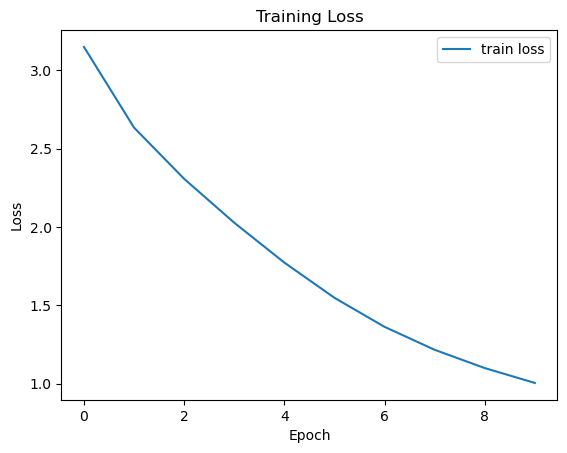

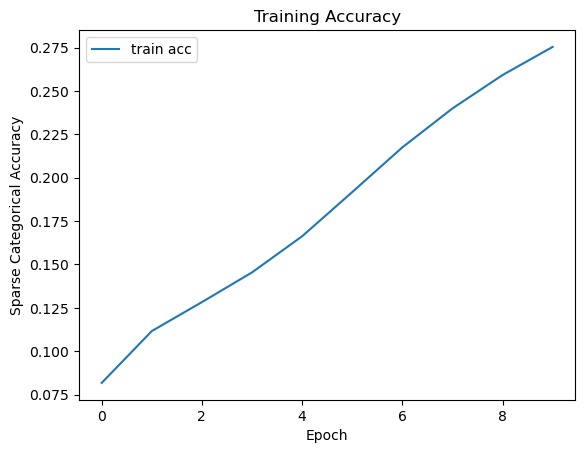

In [19]:
import matplotlib.pyplot as plt

# 학습 결과 기록
hist = history.history

# --- Loss 그래프 ---
plt.plot(hist['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# --- Sparse Categorical Accuracy 그래프 ---
plt.plot(hist['sparse_categorical_accuracy'], label='train acc')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


# 평가하기

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 필수: PAD / <start> / <end> 토큰 ID
PAD_ID   = 0
START_ID = en_tokenizer.word_index.get("<start>")
END_ID   = en_tokenizer.word_index.get("<end>")
assert START_ID is not None and END_ID is not None, "en_tokenizer에 <start>, <end>가 필요합니다."

def preprocess_sentence(text, lang="ko"):
    return preprocessing(text, lang)

PAD_ID = 0

def get_model_max_len(model):
    # model.input_shape == [(None, MAX_LEN), (None, MAX_LEN)] 형태 가정
    enc_len = model.input_shape[0][1]
    dec_len = model.input_shape[1][1]
    if enc_len != dec_len:
        raise ValueError(f"enc_len({enc_len}) != dec_len({dec_len})")
    return enc_len

def ids_to_tokens(tokenizer, ids, stop_at_end=True):
    toks = []
    for i in ids:
        if i == PAD_ID: break
        w = tokenizer.index_word.get(i, "<unk>")
        if stop_at_end and w == "<end>":
            break
        toks.append(w)
    return toks

def evaluate(sentence, model, ko_tokenizer, en_tokenizer, max_len=None):
    model_max_len = get_model_max_len(model) if max_len is None else max_len

    # 1) 인코더 입력(한국어 기준) 전처리/토큰화/패딩
    sent_ko = preprocessing(sentence, "ko")  # 당신의 전처리 함수
    enc_ids = ko_tokenizer.texts_to_sequences([sent_ko])[0]
    enc_ids = enc_ids[:model_max_len]
    enc = pad_sequences([enc_ids], maxlen=model_max_len, padding="post",
                        truncating="post", value=PAD_ID)

    # 2) 디코더 입력 초기화: <start> + PAD
    START_ID = en_tokenizer.word_index.get("<start>")
    END_ID   = en_tokenizer.word_index.get("<end>")
    if START_ID is None or END_ID is None:
        raise ValueError("en_tokenizer에 <start>/<end> 토큰이 필요합니다.")
    dec = np.full((1, model_max_len), PAD_ID, dtype="int32")
    dec[0, 0] = START_ID

    out_ids, attn_rows = [], []

    # 3) greedy 디코딩
    for t in range(1, model_max_len):
        preds = model.predict([enc, dec], verbose=0)
        if isinstance(preds, (list, tuple)):
            logits = preds[0]
            attentions = preds[1] if len(preds) > 1 else None
        else:
            logits = preds
            attentions = None

        next_id = int(np.argmax(logits[0, t-1, :]))
        out_ids.append(next_id)
        dec[0, t] = next_id

        if attentions is not None:
            att = attentions[0]
            # (B, T_dec, T_enc) 또는 (B, T_enc, T_dec) 케이스 처리
            if att.ndim == 3 and att.shape[1] == model_max_len:
                attn_rows.append(att[t-1, :])
            elif att.ndim == 3 and att.shape[2] == model_max_len:
                attn_rows.append(att[:, t-1][0])

        if next_id == END_ID:
            break

    dec_tokens = ids_to_tokens(en_tokenizer, out_ids, stop_at_end=True)
    enc_tokens = ids_to_tokens(ko_tokenizer, enc[0], stop_at_end=False)

    attn_mat = None
    if attn_rows:
        src_len = len(enc_tokens)
        attn_mat = np.stack(attn_rows, axis=0)[:, :src_len]  # (trg_len, src_len)

    return dec_tokens, sent_ko, attn_mat



In [44]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [47]:
def get_model_max_len(model):
    # model.input_shape == [(None, L), (None, L)] 가정
    enc_len = model.input_shape[0][1]
    dec_len = model.input_shape[1][1]
    if enc_len != dec_len:
        raise ValueError(f"enc_len({enc_len}) != dec_len({dec_len})")
    return int(enc_len)

In [48]:
def translate(sentence, model, ko_tokenizer, en_tokenizer):
    pred_tokens, clean_in, attention = evaluate(sentence, model, ko_tokenizer, en_tokenizer)
    print("Input(KO):", clean_in)
    print("Predicted(EN):", " ".join(pred_tokens))
    if attention is not None:
        # x축: 인코더 토큰, y축: 디코더 토큰
        L = get_model_max_len(model)
        enc_ids = ko_tokenizer.texts_to_sequences([clean_in])[0][:L]
        enc_padded = pad_sequences([enc_ids], maxlen=L, padding="post", value=PAD_ID)[0]
        enc_tokens = ids_to_tokens(ko_tokenizer, enc_padded, stop_at_end=False)
        plot_attention(attention, enc_tokens, pred_tokens)

In [50]:
translate("The most powerful man all over the world.", model, ko_tokenizer, en_tokenizer)

Input(KO): The most powerful man all over the world.
Predicted(EN): the ap's jason <unk> reports that the <unk> <unk> is <unk>


# 회고

- GPU랑 메모리 문제로 문제를 많이 겪어서 오래 걸렸다. 원인은 올바른 버전의 tensorflow를 다운받았어야 하는 것과 mecab 다운로드 방식에 문제가 있었다.
- 그리고 왠만하면 다운로드 후에 커널 재시작을 했어야 하는데, 이를 하지 않아서 오류 메시지가 나온 것 같다.
- seq2seq 공부를 하는 데 집중해서 다양한 실험을 못해본 것이 아쉽다.
- 이번 코드 작성도 gpt 의존도가 높아 기분이 좋지는 않다. (언제 다시 보지..)